In [2]:
# Import sys, then tell python where to find the nEXO-specific classes
# I'll assume you're in the sensitivity/work directory, as shown here by !pwd

import sys
!pwd
sys.path.append('../../../modules')

/g/g20/lenardo1/nEXO/sensitivity/work/SensitivityPaper2020_scripts/BaTagging


In [3]:
# Import useful libraries for analysis

import pandas as pd
import histlite as hl
import numpy as np
from matplotlib import pyplot as plt
import os
import pickle

import scipy.optimize as opt

plt.rcParams.update({'font.size': 20})
plt.rcParams['figure.figsize'] = (12,9)

from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
# Import the nEXO sensitivity classes
import nEXOMaterialsDBInterface
import nEXOFitWorkspace
import nEXOFitModel
import nEXOFitLikelihood

import importlib
importlib.reload( nEXOMaterialsDBInterface )
importlib.reload( nEXOFitWorkspace )
importlib.reload( nEXOFitModel )

<module 'nEXOFitModel' from '../../../modules/nEXOFitModel.py'>

# Plot the distributions themselves

In [8]:
datadir = '/usr/workspace/wsa/nexo/lenardo1/baseline2019_third_pass/'

workspace = nEXOFitWorkspace.nEXOFitWorkspace(config='../../config/Sensitivity2020_BaTagging_config.yaml')
workspace.LoadComponentsTableFromFile(datadir + 'ComponentsTable_D-023_merged-v5_final_cuts_ba_tagging.h5')
workspace.CreateGroupedPDFs()





Loading input data froma previously-generated components table....

Loaded dataframe with 171 components.
Contains the following quantities of interest:
	PDFName
	Component
	Isotope
	MC ID
	Total Mass or Area
	Activity ID
	SpecActiv
	SpecActivErr
	SpecActivErrorType
	RawActiv
	RawActivErr
	TotalHitEff_N
	Histogram
	HistogramAxisNames
	TotalHitEff_K
	Group
	Expected Counts

Fit variables:
	['DNN', 'Energy (keV)', 'Standoff (mm)']

Creating grouped PDFs....
	Group:                              	Expected Counts:
	FullLXeBb2n                         	  14544517.2295
	FullLXeBb0n                         	         0.0001
	Total Sum                           	  14544517.2296


Variable name:          Value:       IsFixed:  FitError   InputError:   IsConstrained: Limits:      
Num_FullLXeBb2n         1.454e+07    False     None       3.814e+03     False          (None,None)
Num_FullLXeBb0n         0.0001       False     None       0.01          False          (None,None)
Plotting FullLXeBb2n
Plotting FullLXeBb0n


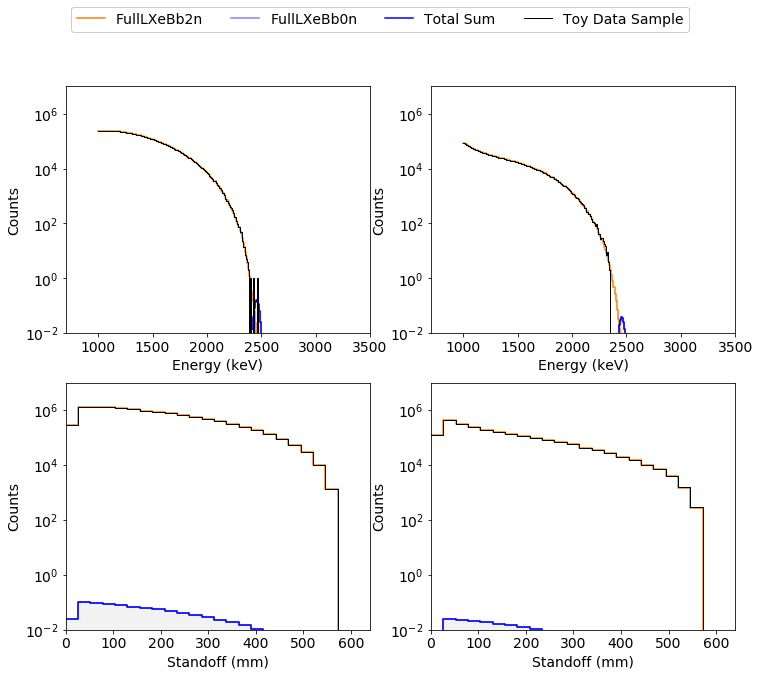

In [13]:
likelihood = nEXOFitLikelihood.nEXOFitLikelihood()
likelihood.AddPDFDataframeToModel( workspace.df_group_pdfs,\
                                  workspace.histogram_axis_names )
likelihood.PrintVariableList()

sig_idx = likelihood.model.GetVariableIndexByName('Bb0n')
likelihood.model.variable_list[sig_idx]['Value'] = 1.

likelihood.model.GenerateModelDistribution()
likelihood.AddDataset( likelihood.model.GenerateDataset() )

ss_cut_dict = {'DNN': (0.8,1.),
               'Energy (keV)': (1000.,3500.),
               'Standoff (mm)': (0.,650.)
              }
ms_cut_dict = {'DNN': (0.,0.8),
               'Energy (keV)': (1000.,3500.),
               'Standoff (mm)': (0.,650.)
              }


likelihood.PlotModelDistributions(ss_cut_dict,ms_cut_dict,save=False,plot_data=True,show=True,output_filename=None)



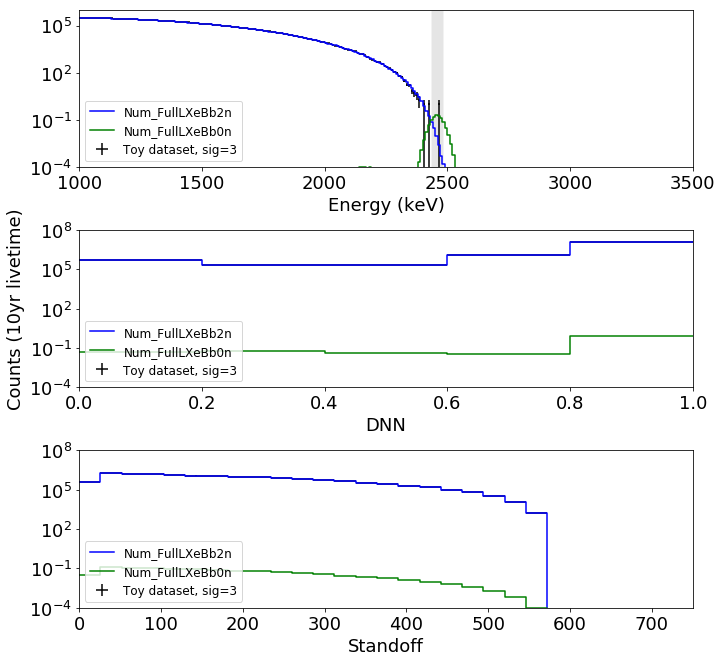

In [14]:
plt.rcParams['figure.figsize'] = (11,11)
plt.rcParams.update({'font.size': 18})
plt.rcParams['axes.prop_cycle'] = cycler(color='bgrcmyk')


fig,ax = plt.subplots(ncols=1,nrows=3,sharex=False,gridspec_kw={'hspace':0.4})


for i in range(2):
    hl.plot1d( ax[0], likelihood.model.pdfs[i].project([1]) * likelihood.model.variable_list[i]['Value'], \
              label='{}'.format(likelihood.model.variable_list[i]['Name']) )
    
    
hl.plot1d( ax[0], likelihood.dataset.project([1]), color='k', crosses=True, label='Toy dataset, sig=3' )
ax[0].legend(fontsize=12, loc='lower left')
ax[0].set_yscale('log')
ax[0].set_ylim(1.e-4,1.e6)
ax[0].set_xlim(1000.,3500.)
ax[0].set_xlabel('Energy (keV)')
ax[0].fill_between([2434.7,2480.95],\
                   [1.e-4,1.e-4],\
                   [1.e6,1.e6,],\
                   edgecolor=(0.,0.,0.,0.),facecolor=(0.,0.,0.,0.1))


#ax[0].set_ylabel('Counts (10yr livetime)')



for i in range(2):
    hl.plot1d( ax[1], likelihood.model.pdfs[i].project([0]) * likelihood.model.variable_list[i]['Value'], \
              label='{}'.format(likelihood.model.variable_list[i]['Name']) )
    
    
hl.plot1d( ax[1], likelihood.dataset.project([0]), color='k', crosses=True, label='Toy dataset, sig=3' )
ax[1].legend(fontsize=12, loc='lower left')
ax[1].set_yscale('log')
ax[1].set_ylim(1.e-4,1.e8)
ax[1].set_xlim(0.,1.)
ax[1].set_xlabel('DNN')
ax[1].set_ylabel('Counts (10yr livetime)')



for i in range(2):
    hl.plot1d( ax[2], likelihood.model.pdfs[i].project([2]) * likelihood.model.variable_list[i]['Value'], \
              label='{}'.format(likelihood.model.variable_list[i]['Name']) )
    
    
hl.plot1d( ax[2], likelihood.dataset.project([2]), color='k', crosses=True, label='Toy dataset, sig=3' )
ax[2].legend(fontsize=12, loc='lower left')
ax[2].set_yscale('log')
ax[2].set_ylim(1.e-4,1.e8)
ax[2].set_xlim(0.,750.)
ax[2].set_xlabel('Standoff')
#ax[2].set_ylabel('Counts (10yr livetime)')

plt.savefig('Plots/projected_distributions_3sigcts_vertical.png',dpi=200,bbox_inches='tight')



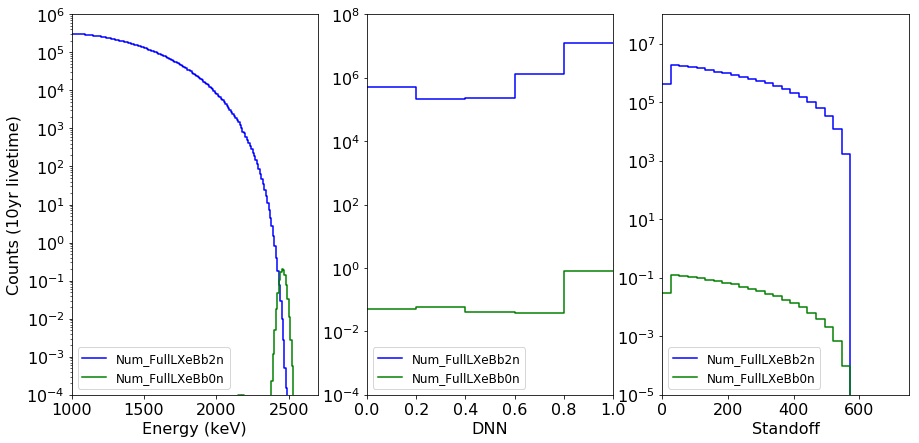

In [19]:
 plt.rcParams['figure.figsize'] = (15,7)
plt.rcParams.update({'font.size': 16})


fig,ax = plt.subplots(ncols=3,nrows=1,sharex=False,gridspec_kw={'hspace':0.4})


for i in range(2):
    #print(len(likelihood.model.pdfs[i]))
    hl.plot1d( ax[0], likelihood.model.pdfs[i].project([1]) * likelihood.model.variable_list[i]['Value'], \
              label='{}'.format(likelihood.model.variable_list[i]['Name']) )
    
    
#hl.plot1d( ax[0], likelihood.dataset.project([1]), color='k', crosses=True, label='Toy dataset, sig=3' )
ax[0].legend(fontsize=12, loc='lower left')
ax[0].set_yscale('log')
ax[0].set_ylim(1.e-4,1.e6)
ax[0].set_xlim(1000.,2700.)
ax[0].set_xlabel('Energy (keV)')
ax[0].set_ylabel('Counts (10yr livetime)')
# ax[0].fill_between([2434.7,2480.95],\
#                    [1.e-4,1.e-4],\
#                    [1.e6,1.e6,],\
#                    edgecolor=(0.,0.,0.,0.),facecolor=(0.,0.,0.,0.1))



for i in range(2):
    hl.plot1d( ax[1], likelihood.model.pdfs[i].project([0]) * likelihood.model.variable_list[i]['Value'], \
              label='{}'.format(likelihood.model.variable_list[i]['Name']) )
    
    
#hl.plot1d( ax[1], likelihood.dataset.project([0]), color='k', crosses=True, label='Toy dataset, sig=3' )
ax[1].legend(fontsize=12, loc='lower left')
ax[1].set_yscale('log')
ax[1].set_ylim(1.e-4,1.e8)
ax[1].set_xlim(0.,1.)
ax[1].set_xlabel('DNN')
#ax[1].set_ylabel('Counts (10yr livetime)')



for i in range(2):
    hl.plot1d( ax[2], likelihood.model.pdfs[i].project([2]) * likelihood.model.variable_list[i]['Value'], \
              label='{}'.format(likelihood.model.variable_list[i]['Name']) )
    
    
#hl.plot1d( ax[2], likelihood.dataset.project([2]), color='k', crosses=True, label='Toy dataset, sig=3' )
ax[2].legend(fontsize=12, loc='lower left')
ax[2].set_yscale('log')
ax[2].set_ylim(1.e-5,1.e8)
ax[2].set_xlim(0.,750.)
ax[2].set_xlabel('Standoff')
#ax[2].set_ylabel('Counts (10yr livetime)')

plt.savefig('Plots/projected_distributions_3sigcts_horizontal.png',dpi=200,bbox_inches='tight')



Hist(4 bins in [0.0,0.8], 250 bins in [1000.0,3500.0], 25 bins in [0.0,650.0], with sum 0.15310610487855314, 12831 empty bins, and 0 non-finite values)
Hist(1 bins in [0.8,1.0], 250 bins in [1000.0,3500.0], 25 bins in [0.0,650.0], with sum 0.846893895121447, 3019 empty bins, and 0 non-finite values)


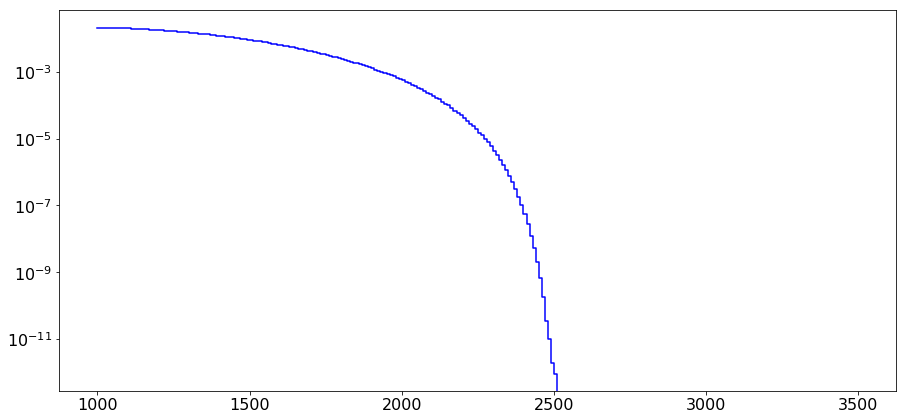

In [20]:
sig_idx = likelihood.model.GetVariableIndexByName('Bb2n')

hl.plot1d( likelihood.model.pdfs[sig_idx].project([1]) )


print(likelihood.model.pdfs[sig_idx][0:1])
print(likelihood.model.pdfs[sig_idx][1:])

plt.yscale('log')

Variable: Num_FullLXeBb2n	Value: 1.454e+07
Variable: Num_FullLXeBb0n	Value:  1.0


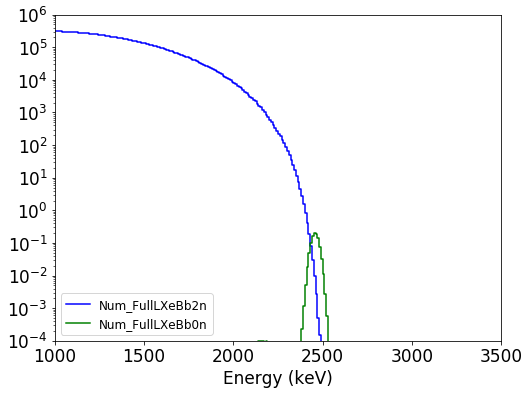

In [21]:
 plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams.update({'font.size': 17})

# weight*(energy<3500. && energy>1000. && \
#         passed_z_thresh && passed_xy_thresh && \
#         standoff > 20. && !NESTBugFound && m_nQ*1.077 + 313 > m_nOPCal && \
#         m_nQ*0.597 - 216 < m_nOPCal && n_x_ch_abovenoise > 0 \
#         && n_y_ch_abovenoise>0)
for i in range(2):
    hl.plot1d( likelihood.model.pdfs[i].project([1]) * likelihood.model.variable_list[i]['Value'], \
              label='{}'.format(likelihood.model.variable_list[i]['Name']) )
    print('Variable: {}\tValue: {:4.4}'.format(likelihood.model.variable_list[i]['Name'],\
                                               likelihood.model.variable_list[i]['Value']))
    
    
#hl.plot1d( likelihood.dataset.project([1]), color='k', crosses=True, label='Toy dataset, sig=3' )
plt.legend(fontsize=12, loc='lower left')
plt.yscale('log')
plt.ylim(1.e-4,1.e6)
plt.xlim(1000.,3500.)
plt.xlabel('Energy (keV)')
# plt.fill_between([2434.7,2480.95],\
#                    [1.e-4,1.e-4],\
#                    [1.e6,1.e6,],\
#                    edgecolor=(0.,0.,0.,0.),facecolor=(0.,0.,0.,0.2))
# plt.grid()

plt.savefig('Plots/bb2n_and_bb0n_energy_spectra_at_10yrs.png',dpi=300,bbox_inches='tight')



In [12]:


critical_lambda_dir = '/p/lustre1/lenardo1/sensitivity_output/October6_2020_critical_lambda_ba_tagging_no_shape_error_histats_final_cuts/'

all_files = os.listdir( critical_lambda_dir )

h5_files = []

for i in range(5):
    h5_files.append( [filename for filename in all_files if filename.endswith('{}.h5'.format(i))] )
    


In [13]:
print(h5_files[0][0])
print(h5_files[1][0])

critical_lambda_calculation_num_sig_4.5_file_0.h5
critical_lambda_calculation_num_sig_14.2_file_1.h5


In [14]:
# dflist = []
# inputcounts = []
# sorteddflist = []

# for i in range(5):
    
#     print('Running {}'.format(i))
    
#     dflist.append([])
#     inputcounts.append([])
#     sorteddflist.append([])

#     for filename in h5_files[i]:
        
#         dflist[i].append( pd.read_hdf( critical_lambda_dir + filename ) )
#         inputcounts[i].append( float(filename.split('_')[-3]) )
#     sorteddflist[i] = [x for _,x in sorted( zip(inputcounts[i], dflist[i]) ) ]

    

In [15]:
# # First, combine the 0 and 1 lists to get one master list
# masterdflist = []

# for i in range(len(sorteddflist[0])):
#     #masterdflist.append( sorteddflist1[i] )
#     print('Running {}'.format(i))
    
#     temp_list = [ sorteddflist[j][i] for j in range(5) ]
#     masterdflist.append( pd.concat( temp_list, ignore_index=True ) )
    
    

In [16]:

# with open(critical_lambda_dir + 'master_df_list_01.pkl','wb') as pklfile:
#     pickle.dump(masterdflist,pklfile)

with open(critical_lambda_dir+'master_df_list_01.pkl','rb') as pklfile:
    masterdflist = pickle.load(pklfile)


In [17]:

for colname in masterdflist[0].columns:
    print(colname)
    
for index, row in masterdflist[3].iterrows():
    if index>3: break
    print(row['num_signal'])
    
    

best_fit_converged
best_fit_covar
best_fit_errors
best_fit_iterations
best_fit_parameters
fixed_fit_converged
fixed_fit_covar
fixed_fit_errors
fixed_fit_iterations
fixed_fit_parameters
input_parameters
lambda
num_signal
0.375
0.375
0.375
0.375


Fitted mean: 1.4544e+07
Fitted width: 4.1217e+05
Relative width: 0.02834 (2.834 +/- 0.007592%)


Text(0.5, 0, '')

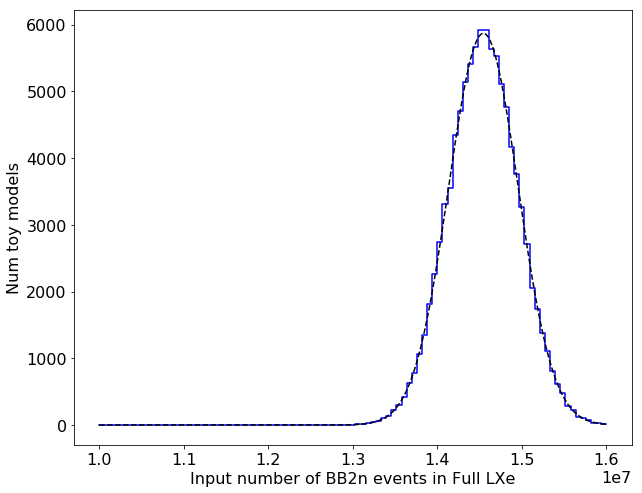

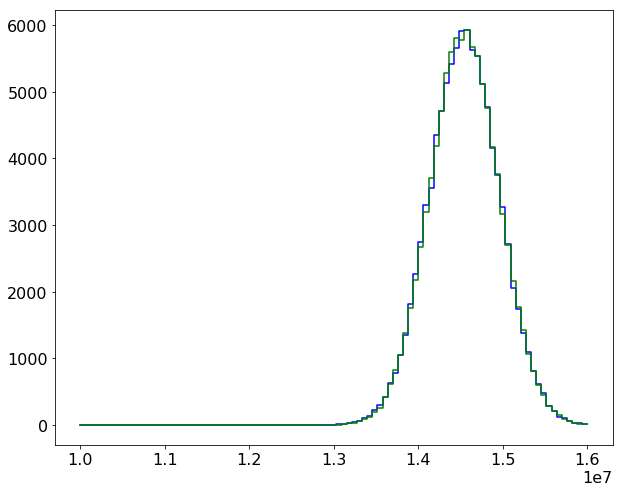

In [21]:
# plt.rcParams['figure.figsize'] = (10,8)


# # Plot distribution of input values for BB2n
# def Gaussian(x,A,mu,sig):
#     return A*np.exp(-(x-mu)**2/(2*sig**2))




# input_bb2n_array = np.zeros(len(masterdflist[0]))
# for index,row in masterdflist[0].iterrows():
#     input_bb2n_array[index] = row['input_parameters']['Num_FullLXeBb2n']


# h_bb2n_inputs = hl.hist( input_bb2n_array, \
#                         bins=np.linspace( 10e6, 16e6, 100 )  )

# hl.plot1d(h_bb2n_inputs)

# bincenters = (h_bb2n_inputs.bins[0][0:-1] + h_bb2n_inputs.bins[0][1:])/2.
# binvalues = h_bb2n_inputs.values

# p,pcov = opt.curve_fit( Gaussian, bincenters, binvalues, p0=(175.,1.45e7, 5.e5) )

# xfit = np.linspace( 10e6, 16e6, 1000 )
# yfit = Gaussian(xfit,p[0],p[1],p[2])

# plt.plot(xfit,yfit,'--k')

# print('Fitted mean: {:5.5}'.format(p[1]))
# print('Fitted width: {:5.5}'.format(p[2]))
# print('Relative width: {:4.4} ({:4.4} +/- {:4.4}%)'.format( p[2]/p[1], \
#                                                            p[2]/p[1]*100, \
#                                                           np.sqrt(pcov[2,2])/p[1]*100 ) )

# plt.xlabel('Input number of BB2n events in Full LXe')
# plt.ylabel('Num toy models')






# plt.figure(2)
# input_bb2n_array = np.zeros(len(masterdflist[20]))
# for index,row in masterdflist[20].iterrows():
#     input_bb2n_array[index] = row['input_parameters']['Num_FullLXeBb2n']


# h_bb2n_inputs2 = hl.hist( input_bb2n_array, \
#                         bins=np.linspace( 10e6, 16e6, 100 )  )

# hl.plot1d(h_bb2n_inputs)
# hl.plot1d(h_bb2n_inputs2)
# plt.xlabel('')




Fitted mean: 1.4545e+07
Fitted width: 4.1058e+05
Relative width: 0.02823 (2.823%)


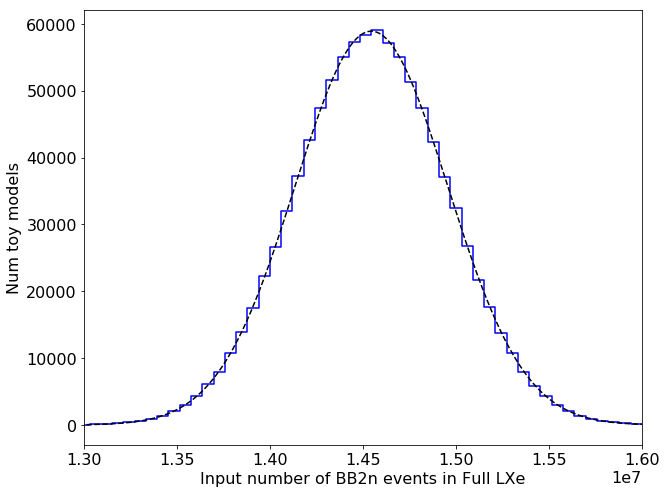

In [22]:
# plt.rcParams['figure.figsize'] = (10,8)


# concat_df = pd.concat( masterdflist[0:10], ignore_index=True )

# input_bb2n_array = np.zeros(len(concat_df))
# for index,row in concat_df.iterrows():
#     input_bb2n_array[index] = row['input_parameters']['Num_FullLXeBb2n']


# h_bb2n_inputs = hl.hist( input_bb2n_array, \
#                         bins=np.linspace( 10e6, 16e6, 100 )  )

# hl.plot1d(h_bb2n_inputs)

# bincenters = (h_bb2n_inputs.bins[0][0:-1] + h_bb2n_inputs.bins[0][1:])/2.
# binvalues = h_bb2n_inputs.values

# p,pcov = opt.curve_fit( Gaussian, bincenters, binvalues, p0=(175.,1.65e7, 5.e5) )

# xfit = np.linspace( 10e6, 16e6, 1000 )
# yfit = Gaussian(xfit,p[0],p[1],p[2])

# plt.plot(xfit,yfit,'--k')

# plt.xlim(1.3e7,1.6e7)

# print('Fitted mean: {:5.5}'.format(p[1]))
# print('Fitted width: {:5.5}'.format(p[2]))
# print('Relative width: {:4.4} ({:4.4}%)'.format( p[2]/p[1], p[2]/p[1]*100 ) )

# plt.xlabel('Input number of BB2n events in Full LXe')
# plt.ylabel('Num toy models')

# plt.savefig('Plots/fluctuations_in_bb2n.png',dpi=200,bbox_inches='tight')




# Making the critical lamba curve




In [16]:
hypotheses = np.linspace(0.,25.,25*8+1)
print(hypotheses)


[ 0.     0.125  0.25   0.375  0.5    0.625  0.75   0.875  1.     1.125
  1.25   1.375  1.5    1.625  1.75   1.875  2.     2.125  2.25   2.375
  2.5    2.625  2.75   2.875  3.     3.125  3.25   3.375  3.5    3.625
  3.75   3.875  4.     4.125  4.25   4.375  4.5    4.625  4.75   4.875
  5.     5.125  5.25   5.375  5.5    5.625  5.75   5.875  6.     6.125
  6.25   6.375  6.5    6.625  6.75   6.875  7.     7.125  7.25   7.375
  7.5    7.625  7.75   7.875  8.     8.125  8.25   8.375  8.5    8.625
  8.75   8.875  9.     9.125  9.25   9.375  9.5    9.625  9.75   9.875
 10.    10.125 10.25  10.375 10.5   10.625 10.75  10.875 11.    11.125
 11.25  11.375 11.5   11.625 11.75  11.875 12.    12.125 12.25  12.375
 12.5   12.625 12.75  12.875 13.    13.125 13.25  13.375 13.5   13.625
 13.75  13.875 14.    14.125 14.25  14.375 14.5   14.625 14.75  14.875
 15.    15.125 15.25  15.375 15.5   15.625 15.75  15.875 16.    16.125
 16.25  16.375 16.5   16.625 16.75  16.875 17.    17.125 17.25  17.375
 17.5 

In [18]:
## Make the histograms for different values of the signal PDF
hist_list = []
array_list = []

for i in range(len(masterdflist)):
    
    mask = masterdflist[i]['fixed_fit_covar'] & masterdflist[i]['best_fit_covar']
    
    if i % 2 == 0:
        print('Hypothesis: {:4.4} cts \t Fit convergence: {:4.4}%'.format(\
                            hypotheses[i], np.sum(mask)/len(mask)*100))
    
    hist_list.append( hl.hist( masterdflist[i]['lambda'].loc[mask], bins=np.linspace(0.,20.,100) ) )
    
    array_list.append( masterdflist[i]['lambda'].loc[mask] )
    



Hypothesis:  0.0 cts 	 Fit convergence: 100.0%
Hypothesis: 0.25 cts 	 Fit convergence: 100.0%
Hypothesis:  0.5 cts 	 Fit convergence: 100.0%
Hypothesis: 0.75 cts 	 Fit convergence: 100.0%
Hypothesis:  1.0 cts 	 Fit convergence: 100.0%
Hypothesis: 1.25 cts 	 Fit convergence: 100.0%
Hypothesis:  1.5 cts 	 Fit convergence: 100.0%
Hypothesis: 1.75 cts 	 Fit convergence: 100.0%
Hypothesis:  2.0 cts 	 Fit convergence: 100.0%
Hypothesis: 2.25 cts 	 Fit convergence: 100.0%
Hypothesis:  2.5 cts 	 Fit convergence: 100.0%
Hypothesis: 2.75 cts 	 Fit convergence: 100.0%
Hypothesis:  3.0 cts 	 Fit convergence: 100.0%
Hypothesis: 3.25 cts 	 Fit convergence: 100.0%
Hypothesis:  3.5 cts 	 Fit convergence: 100.0%
Hypothesis: 3.75 cts 	 Fit convergence: 100.0%
Hypothesis:  4.0 cts 	 Fit convergence: 100.0%
Hypothesis: 4.25 cts 	 Fit convergence: 100.0%
Hypothesis:  4.5 cts 	 Fit convergence: 100.0%
Hypothesis: 4.75 cts 	 Fit convergence: 100.0%
Hypothesis:  5.0 cts 	 Fit convergence: 100.0%
Hypothesis: 5

In [1]:
# Plot a few examples
plt.rcParams['figure.figsize'] = (8,11)

fig, ax = plt.subplots( ncols=1, nrows=6, sharex=True, gridspec_kw={'hspace':0.} )

for i in range(5):
    hl.plot1d( ax[i], hist_list[i*5], label='{:4.4} counts'.format(hypotheses[i*5]) )
    ax[i].legend()
    ax[i].set_yscale('log')
    ax[i].set_xlim(0.,20.)


hl.plot1d( ax[5], hist_list[50], label='{:4.4} counts'.format(hypotheses[50]) )
ax[5].legend()
ax[5].set_yscale('log')
ax[5].set_xlim(0.,20.)


NameError: name 'plt' is not defined

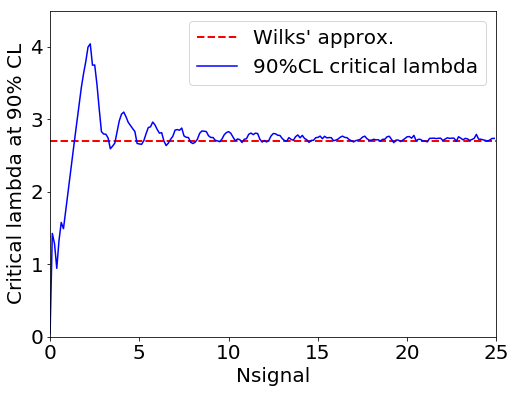

In [20]:
from scipy.interpolate import LSQUnivariateSpline
plt.rcParams['figure.figsize'] = (8,6)

thresholds = [ np.quantile( array, 0.90 ) for array in array_list]

xarray = np.linspace(0.,60.,300)
plt.plot(xarray,np.ones(300)*2.706,'--r',linewidth=2,label='Wilks\' approx.')



plt.plot( np.array(hypotheses[0:-1]), np.array(thresholds), '-b'  , label='90%CL critical lambda')
plt.xlim(0.,25.)
plt.ylim(0.,4.5)
plt.xlabel('Nsignal')
plt.ylabel('Critical lambda at 90% CL')

plt.legend()

plt.savefig('Plots/critical_lambda_calculated_vs_wilks_approx.png',dpi=200,bbox_inches='tight')

# critical_lambda_data = np.transpose( np.genfromtxt('critical_lambda_ba_tagging.txt') )
# spline_xn = np.append( np.linspace(1.,15.,29), np.linspace(16., 25., 5) ) # Defines the locations of the knots
# spline_xn = np.append( spline_xn, 50. ) # Defines the locations of the knots
# #SplineFunc = LSQUnivariateSpline(np.array(hypotheses[0:-1]),np.array(thresholds),t = spline_xn)
# SplineFunc = LSQUnivariateSpline(critical_lambda_data[:,0],critical_lambda_data[:,1],t = spline_xn)








(1.0, 3.5)

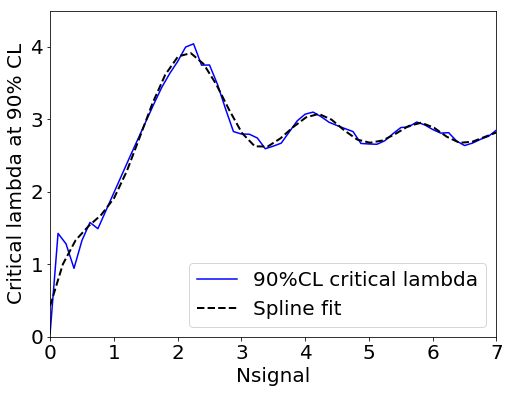

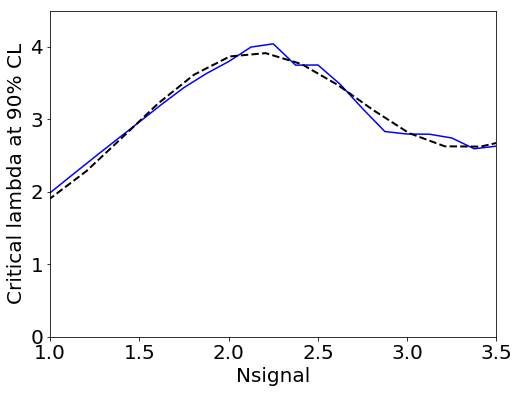

In [21]:
from scipy.interpolate import LSQUnivariateSpline
plt.rcParams['figure.figsize'] = (8,6)

thresholds = [ np.quantile( array, 0.90 ) for array in array_list]

plt.plot( np.array(hypotheses[0:-1]), np.array(thresholds), '-b'  , label='90%CL critical lambda')
plt.xlim(0.,25.)
plt.ylim(0.,4.5)
plt.xlabel('Nsignal')
plt.ylabel('Critical lambda at 90% CL')


critical_lambda_data = np.transpose( np.genfromtxt('critical_lambda_ba_tagging.txt') )
spline_xn = np.append( np.linspace(1.,15.,27), np.linspace(16., 25., 5) ) # Defines the locations of the knots
spline_xn = np.append( spline_xn, 50. ) # Defines the locations of the knots
#SplineFunc = LSQUnivariateSpline(np.array(hypotheses[0:-1]),np.array(thresholds),t = spline_xn)
SplineFunc = LSQUnivariateSpline(critical_lambda_data[:,0],critical_lambda_data[:,1],t = spline_xn)

xarray = np.linspace(0.,60.,300)
yarray = SplineFunc(xarray)
plt.plot(xarray,yarray,'--k',linewidth=2,label='Spline fit')

plt.legend()
plt.xlim(0.,7.)
plt.savefig('Plots/critical_lambda_with_spline_fit.png',dpi=200,bbox_inches='tight')



plt.figure(2)
plt.plot( np.array(hypotheses[0:-1]), np.array(thresholds), '-b'  , label='90%CL critical lambda')
plt.xlim(0.,25.)
plt.ylim(0.,4.5)
plt.xlabel('Nsignal')
plt.ylabel('Critical lambda at 90% CL')
plt.plot(xarray,yarray,'--k',linewidth=2,label='Spline fit')
plt.xlim(1.,3.5)




In [28]:
dat = np.transpose( np.array( [np.array(hypotheses[0:-1]), np.array(thresholds)] ) )
#print(dat)

extrapolation_x = np.linspace(25,61,20)
extrapolation_y = np.ones(20)*2.701

extrapolation = np.transpose( np.array( [extrapolation_x,extrapolation_y] ) )

dat = np.vstack( [dat, extrapolation]  )
print(dat)
np.savetxt('critical_lambda_ba_tagging.txt',np.transpose(dat),delimiter='\t')




[[0.00000000e+00 4.39819694e-02]
 [1.25000000e-01 1.42663888e+00]
 [2.50000000e-01 1.28253934e+00]
 [3.75000000e-01 9.44676110e-01]
 [5.00000000e-01 1.32886330e+00]
 [6.25000000e-01 1.57773691e+00]
 [7.50000000e-01 1.49186226e+00]
 [8.75000000e-01 1.73996921e+00]
 [1.00000000e+00 1.98835290e+00]
 [1.12500000e+00 2.23475723e+00]
 [1.25000000e+00 2.48112658e+00]
 [1.37500000e+00 2.72376089e+00]
 [1.50000000e+00 2.96376897e+00]
 [1.62500000e+00 3.20745435e+00]
 [1.75000000e+00 3.43874958e+00]
 [1.87500000e+00 3.63141570e+00]
 [2.00000000e+00 3.79722389e+00]
 [2.12500000e+00 3.99719184e+00]
 [2.25000000e+00 4.04205253e+00]
 [2.37500000e+00 3.74771242e+00]
 [2.50000000e+00 3.75013900e+00]
 [2.62500000e+00 3.48345090e+00]
 [2.75000000e+00 3.14884185e+00]
 [2.87500000e+00 2.83194087e+00]
 [3.00000000e+00 2.79765906e+00]
 [3.12500000e+00 2.79495587e+00]
 [3.25000000e+00 2.74297199e+00]
 [3.37500000e+00 2.59454389e+00]
 [3.50000000e+00 2.63033953e+00]
 [3.62500000e+00 2.67204616e+00]
 [3.750000

In [29]:
import numpy as np
hypotheses_fine = np.linspace(0.,2.6,104+1)
print(hypotheses_fine)

[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.    1.025 1.05  1.075 1.1   1.125 1.15  1.175
 1.2   1.225 1.25  1.275 1.3   1.325 1.35  1.375 1.4   1.425 1.45  1.475
 1.5   1.525 1.55  1.575 1.6   1.625 1.65  1.675 1.7   1.725 1.75  1.775
 1.8   1.825 1.85  1.875 1.9   1.925 1.95  1.975 2.    2.025 2.05  2.075
 2.1   2.125 2.15  2.175 2.2   2.225 2.25  2.275 2.3   2.325 2.35  2.375
 2.4   2.425 2.45  2.475 2.5   2.525 2.55  2.575 2.6  ]


# Finer critical lambda calculations near 0 for Ba-tagging case

In [31]:
critical_lambda_dir = '/p/lustre1/lenardo1/sensitivity_output/October9_2020_critical_lambda_ba_tagging_finer_spacing/'

all_files = os.listdir( critical_lambda_dir )

h5_files = []

for i in range(5):
    h5_files.append( [filename for filename in all_files if filename.endswith('{}.h5'.format(i))] )
    


In [32]:
# dflist = []
# inputcounts = []
# sorteddflist = []

# for i in range(5):
    
#     print('Running {}'.format(i))
    
#     dflist.append([])
#     inputcounts.append([])
#     sorteddflist.append([])

#     for filename in h5_files[i]:
        
#         dflist[i].append( pd.read_hdf( critical_lambda_dir + filename ) )
#         inputcounts[i].append( float(filename.split('_')[-3]) )
#     sorteddflist[i] = [x for _,x in sorted( zip(inputcounts[i], dflist[i]) ) ]


In [33]:
# # First, combine the 0 and 1 lists to get one master list
# masterdflist = []

# for i in range(len(sorteddflist[0])-1):
#     #masterdflist.append( sorteddflist1[i] )
#     print('Running {}'.format(i))
    
#     temp_list = [ sorteddflist[j][i] for j in range(5) ]
#     masterdflist.append( pd.concat( temp_list, ignore_index=True ) )

In [34]:
# import pickle
# with open(critical_lambda_dir + 'master_df_list.pkl','wb') as pklfile:
#     pickle.dump(masterdflist,pklfile)

with open(critical_lambda_dir+'master_df_list.pkl','rb') as pklfile:
    masterdflist = pickle.load(pklfile)

In [35]:
## Make the histograms for different values of the signal PDF
hist_list_fine = []
array_list_fine = []
hypotheses_fine = np.linspace(0.,2.6,104+1)

for i in range(len(masterdflist)):
    
    mask = masterdflist[i]['fixed_fit_covar'] & masterdflist[i]['best_fit_covar']
    
    if i % 2 == 0:
        print('Hypothesis: {:4.4} cts \t Fit convergence: {:4.4}%'.format(\
                            hypotheses_fine[i], np.sum(mask)/len(mask)*100))
    
    hist_list_fine.append( hl.hist( masterdflist[i]['lambda'].loc[mask], bins=np.linspace(0.,20.,100) ) )
    
    array_list_fine.append( masterdflist[i]['lambda'].loc[mask] )
    
    
    

Hypothesis:  0.0 cts 	 Fit convergence: 100.0%
Hypothesis: 0.05 cts 	 Fit convergence: 100.0%
Hypothesis:  0.1 cts 	 Fit convergence: 100.0%
Hypothesis: 0.15 cts 	 Fit convergence: 100.0%
Hypothesis:  0.2 cts 	 Fit convergence: 100.0%
Hypothesis: 0.25 cts 	 Fit convergence: 100.0%
Hypothesis:  0.3 cts 	 Fit convergence: 100.0%
Hypothesis: 0.35 cts 	 Fit convergence: 100.0%
Hypothesis:  0.4 cts 	 Fit convergence: 100.0%
Hypothesis: 0.45 cts 	 Fit convergence: 100.0%
Hypothesis:  0.5 cts 	 Fit convergence: 100.0%
Hypothesis: 0.55 cts 	 Fit convergence: 100.0%
Hypothesis:  0.6 cts 	 Fit convergence: 100.0%
Hypothesis: 0.65 cts 	 Fit convergence: 100.0%
Hypothesis:  0.7 cts 	 Fit convergence: 100.0%
Hypothesis: 0.75 cts 	 Fit convergence: 100.0%
Hypothesis:  0.8 cts 	 Fit convergence: 100.0%
Hypothesis: 0.85 cts 	 Fit convergence: 100.0%
Hypothesis:  0.9 cts 	 Fit convergence: 100.0%
Hypothesis: 0.95 cts 	 Fit convergence: 100.0%
Hypothesis:  1.0 cts 	 Fit convergence: 100.0%
Hypothesis: 1

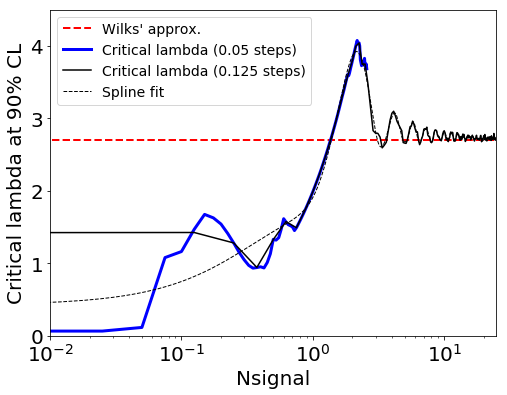

In [36]:
from scipy.interpolate import LSQUnivariateSpline
plt.rcParams['figure.figsize'] = (8,6)

thresholds_fine = [ np.quantile( array, 0.90 ) for array in array_list_fine]

xarray = np.linspace(0.,60.,300)
plt.plot(xarray,np.ones(300)*2.706,'--r',linewidth=2,label='Wilks\' approx.')



plt.plot( np.array(hypotheses_fine[0:-1]), np.array(thresholds_fine), \
         '-b', linewidth=3  , label='Critical lambda (0.05 steps)')
plt.plot(np.array(hypotheses[0:-1]), np.array(thresholds),'-',\
         color=(0.,0.,0.),label='Critical lambda (0.125 steps)')

xarray = np.linspace(0.,60.,10000)
yarray = SplineFunc(xarray)
plt.plot(xarray,yarray,'--k',linewidth=1,label='Spline fit')


plt.xlim(0.,25)
plt.ylim(0.,4.5)
plt.xlabel('Nsignal')
plt.ylabel('Critical lambda at 90% CL')
plt.xscale('log')
plt.xlim(0.01,25.)

plt.legend(fontsize=14)

plt.savefig('Plots/critical_lambda_calculated_vs_wilks_approx_with_finer_steps.png',dpi=200,bbox_inches='tight')


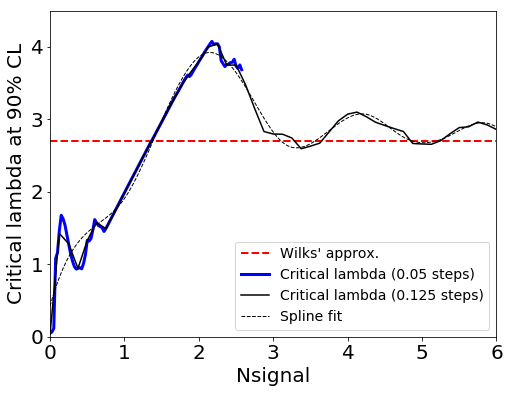

In [37]:
from scipy.interpolate import LSQUnivariateSpline
plt.rcParams['figure.figsize'] = (8,6)

thresholds_fine = [ np.quantile( array, 0.90 ) for array in array_list_fine]

xarray = np.linspace(0.,60.,300)
plt.plot(xarray,np.ones(300)*2.706,'--r',linewidth=2,label='Wilks\' approx.')



plt.plot( np.array(hypotheses_fine[0:-1]), np.array(thresholds_fine), \
         '-b', linewidth=3  , label='Critical lambda (0.05 steps)')
plt.plot(np.array(hypotheses[0:-1]), np.array(thresholds),'-',\
         color=(0.,0.,0.),label='Critical lambda (0.125 steps)')

xarray = np.linspace(0.,60.,10000)
yarray = SplineFunc(xarray)
plt.plot(xarray,yarray,'--k',linewidth=1,label='Spline fit')


plt.xlim(0.,25)
plt.ylim(0.,4.5)
plt.xlabel('Nsignal')
plt.ylabel('Critical lambda at 90% CL')
#plt.xscale('log')
plt.xlim(0.0,6.)

plt.legend(fontsize=14)

plt.savefig('Plots/critical_lambda_calculated_vs_wilks_approx_with_finer_steps_linear.png',dpi=200,bbox_inches='tight')


283
38


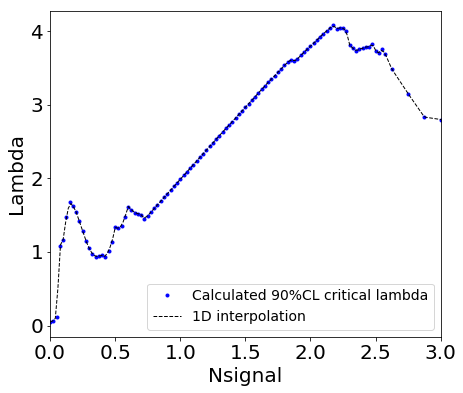

In [38]:
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d

plt.rcParams['figure.figsize'] = (7,6)

mask = hypotheses > hypotheses_fine[-2]

new_thresholds = np.append(np.array(thresholds_fine),np.array(thresholds)[mask[:-1]])
new_hypotheses = np.append(hypotheses_fine[0:-1],hypotheses[mask])

plt.plot(new_hypotheses[0:-1],new_thresholds,'.b',label='Calculated 90%CL critical lambda')
plt.xlim(0.,20.)

spline_xn = np.append( np.linspace(0.,2.5,5),np.linspace(2.7,15.,27) )
spline_xn = np.append( spline_xn, np.linspace(16., 25., 5) ) # Defines the locations of the knots
spline_xn = np.append( spline_xn, 50. ) # Defines the locations of the knots
print(len(new_thresholds))
print(len(spline_xn))
#SplineFunc = LSQUnivariateSpline(np.array(hypotheses[0:-1]),np.array(thresholds),t = spline_xn)
#SplineFuncFine = LSQUnivariateSpline(new_hypotheses[:-1],new_thresholds,t = spline_xn)
#SplineFuncFine = UnivariateSpline(new_hypotheses[:-1],new_thresholds)

SplineFuncFine = interp1d(new_hypotheses[:-1],new_thresholds)

x = np.linspace(0.,20.,1000)
y = SplineFuncFine(x)

plt.plot(x,y,'--k',linewidth=1,label='1D interpolation')
plt.legend(fontsize=14)
plt.xlim(0.,10.)
plt.xlabel('Nsignal')
plt.ylabel('Lambda')
plt.savefig('Plots/critical_lambda_1d_interpolation.png',dpi=200,bbox_inches='tight')

plt.xlim(0.,3.)
plt.savefig('Plots/critical_lambda_1d_interpolation_zoomedin.png',dpi=200,bbox_inches='tight')






#plt.plot(spline_xn, SplineFunc(spline_xn),'.k')

output_critical_lambda_data = np.transpose(np.vstack((new_hypotheses[:-1],new_thresholds)))



np.savetxt('critical_lambda_ba_tagging_fine.txt',output_critical_lambda_data)





(0.0, 3.0)

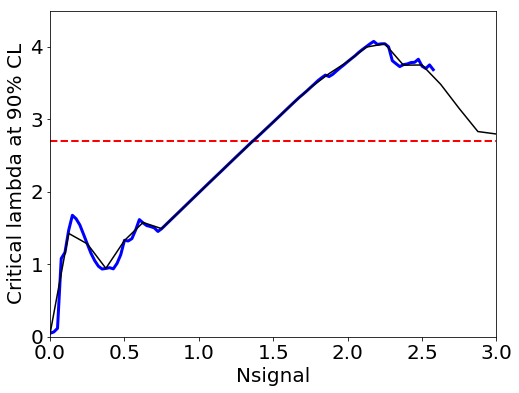

In [45]:
from scipy.interpolate import LSQUnivariateSpline
plt.rcParams['figure.figsize'] = (8,6)

thresholds_fine = [ np.quantile( array, 0.90 ) for array in array_list_fine]

xarray = np.linspace(0.,60.,300)
plt.plot(xarray,np.ones(300)*2.706,'--r',linewidth=2,label='Wilks\' approx.')



plt.plot( np.array(hypotheses_fine[0:-1]), np.array(thresholds_fine), \
         '-b', linewidth=3  , label='Critical lambda (0.05 steps)')
plt.plot(np.array(hypotheses[0:-1]), np.array(thresholds),'-',\
         color=(0.,0.,0.),label='Critical lambda (0.125 steps)')

plt.ylim(0.,4.5)
plt.xlabel('Nsignal')
plt.ylabel('Critical lambda at 90% CL')
#plt.xscale('log')
plt.xlim(0.0,3.)

#plt.legend(fontsize=14)

# Testing the slicing functionality


In [ ]:
print(likelihood.model.axis_names)

In [ ]:
importlib.reload( nEXOMaterialsDBInterface )
importlib.reload( nEXOFitWorkspace )
importlib.reload( nEXOFitModel )

In [ ]:
datadir = '/usr/workspace/wsa/nexo/lenardo1/baseline2019_third_pass/'

workspace = nEXOFitWorkspace.nEXOFitWorkspace(config='../../config/Sensitivity2020_BaTagging_config.yaml')
workspace.LoadComponentsTableFromFile(datadir + 'ComponentsTable_D-023_merged-v5_final_cuts_ba_tagging.h5')
workspace.CreateGroupedPDFs()

likelihood = nEXOFitLikelihood.nEXOFitLikelihood()
likelihood.AddPDFDataframeToModel( workspace.df_group_pdfs,\
                                  workspace.histogram_axis_names )
likelihood.PrintVariableList()

sig_idx = likelihood.model.GetVariableIndexByName('Bb0n')
likelihood.model.variable_list[sig_idx]['Value'] = 3.

likelihood.model.GenerateModelDistribution()
likelihood.AddDataset( likelihood.model.GenerateDataset() )

In [ ]:
ss_cut_dict = {'DNN': (0.8,1.),
               'Energy (keV)': (1000.,3500.),
               'Standoff (mm)': (0.,650.)
              }

inner2t_cut_dict = {'DNN': (0.8,1.),
               'Energy (keV)': (1000.,3500.),
               'Standoff (mm)': (100.,650.)
              }

hist = likelihood.model.GetSlicedDistribution( ss_cut_dict, var_name = 'Bb2n' )
hist2 = likelihood.model.GetSlicedDistribution( inner2t_cut_dict, var_name = 'Bb2n' )

hl.plot1d(hist.project([1]))
hl.plot1d(hist2.project([1]))

plt.yscale('log')



In [ ]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,6)

full_cut_dict = {'DNN': (0.,1.),
               'Energy (keV)': (1000.,3500.),
               'Standoff (mm)': (100.,650.)
              }

hist_bb2n = likelihood.model.GetSlicedDistribution( full_cut_dict, var_name = 'Bb2n', renormalize=True)
hist_bb0n = likelihood.model.GetSlicedDistribution( full_cut_dict, var_name = 'Bb0n', renormalize=True)
hl.plot1d( hist_bb2n.project([0]), label='Bb2n' )
hl.plot1d( hist_bb0n.project([0]), label='Bb0n' )

plt.xlim(0.,1.)
plt.ylim(0.,1.)
plt.legend()
plt.xlabel('DNN')
plt.ylabel('Counts')
plt.title('Full distribution projected onto DNN axis (normalized)',fontsize=17)
plt.savefig('Plots/dnn_projections_for_bb2n_and_bb0n_full.png',dpi=200,bbox_inches='tight')




In [ ]:
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = (8,6)

energy_cut_dict = {'DNN': (0.,1.),
               'Energy (keV)': (2400.,2500.),
               'Standoff (mm)': (100.,650.)
              }

hist_bb2n = likelihood.model.GetSlicedDistribution( energy_cut_dict, var_name = 'Bb2n', renormalize=True)
hist_bb0n = likelihood.model.GetSlicedDistribution( energy_cut_dict, var_name = 'Bb0n', renormalize=True)
hl.plot1d( hist_bb2n.project([0]), label='Bb2n' )
hl.plot1d( hist_bb0n.project([0]), label='Bb0n' )

plt.xlim(0.,1.)
plt.ylim(0.,1.)
plt.legend()
plt.xlabel('DNN')
plt.ylabel('Counts')
plt.title('Energy: 2400 - 2500 keV, projected onto DNN (normalized)',fontsize=16)
plt.savefig('Plots/dnn_projections_for_bb2n_and_bb0n_2400-2500keV.png',dpi=200,bbox_inches='tight')



